In [2]:
source('source.r')

make.div.pal = function(x=100, n, pal='Spectral', lim = c(-1e5, 1e5)) {
    x[x > lim[2]] = lim[2]
    x[x < lim[1]] = lim[1]
    get.div.pal(n, pal=pal)[as.numeric(cut(x, breaks = n))]
}

Packages Loaded:
ncdf4 R.matlab openxlsx RColorBrewer compiler lattice geosphere readxl data.table rworldmap rworldxtra


Loading required package: ncdf4
Loading required package: R.matlab
Warning message:
"package 'R.matlab' was built under R version 3.4.3"R.matlab v3.6.1 (2016-10-19) successfully loaded. See ?R.matlab for help.

Attaching package: 'R.matlab'

The following objects are masked from 'package:base':

    getOption, isOpen

Loading required package: openxlsx
Warning message:
"package 'openxlsx' was built under R version 3.4.3"Loading required package: RColorBrewer
Loading required package: compiler
Loading required package: lattice
Warning message:
"package 'lattice' was built under R version 3.4.3"Loading required package: geosphere
Warning message:
"package 'geosphere' was built under R version 3.4.3"Loading required package: readxl
Loading required package: data.table
Warning message:
"package 'data.table' was built under R version 3.4.3"Loading required package: rworldmap
Warning message:
"package 'rworldmap' was built under R version 3.4.3"Loading required package: sp
Warning message:
"

# Diurnal Signal Module

In [3]:
load(file='./RStates/ship.ncp.rdata')

In [14]:
unique(ship.data$Cycle)
l.eims = which(ship.data$Cycle == 'Cycle1' & ship.data$EIMS.O2.Ar.FLAG == 1)
l.mims = which(ship.data$Cycle == 'Cycle1' & ship.data$MIMS.O2.Ar.FLAG == 1)

pdf('Output/Module Diurnal - Cycle 1 2.pdf')

plot(ship.data$DT[l.eims], ship.data$NCP.EIMS[l.eims], pch=16, cex=0.5, ylim=c(-50, 150), main='Cycle 1',
    ylab='NCP (mmol O2 m-2 d-1)', xlab='')
points(ship.data$DT[l.mims], ship.data$NCP.MIMS[l.mims], pch=16, cex=0.5, col='red')
add.daynight()


## Cycle 2
l.eims = which(ship.data$Cycle == 'Cycle2' & ship.data$EIMS.O2.Ar.FLAG == 1)
l.mims = which(ship.data$Cycle == 'Cycle2' & ship.data$MIMS.O2.Ar.FLAG == 1)

plot(ship.data$DT[l.eims], ship.data$NCP.EIMS[l.eims], pch=16, cex=0.5, ylim=c(-50, 150), main='Cycle 2',
    ylab='NCP (mmol O2 m-2 d-1)', xlab='')
points(ship.data$DT[l.mims], ship.data$NCP.MIMS[l.mims], pch=16, cex=0.5, col='red')
add.daynight()

dev.off()

[1] "Cycle0"             "SeaSoar1"           "Transect1"         
 [4] "MVP Transect 1"     "Cycle1"             "MVP Transect 3"    
 [7] "Cycle2"             "MVP Transect 4"     "Transect2"         
[10] "MVP Transect 5"     "Cycle3"             "Bowtie 1"          
[13] "Transect3"          "Bowtie 2"           "Cycle4"            
[16] "SeaSoar2"           "BBL"                "Santa Cruz Basin 1"
[19] "TransComp"          "Santa Cruz Basin 2"

png 
  2

In [15]:
##Filter based on distance from ship

distance.filter = function(data, d = 500) {
    l = rep(FALSE, nrow(data))
    
    for (i in 1:nrow(data)) {
        dis = distm(c(ship.data$LO[i], ship.data$LA[i]),
                    c(ship.data$Drifter.lon[i],
                      ship.data$Drifter.lat[i]), fun = distHaversine)
        
        ## If qualifies, then set l to TRUE
        if (dis < d) {
            l[i] = TRUE
        }
    }
    data[l,]
}

determine.dist = function() {
    n = c()
    d = seq(100, 5000, 100)
    
    for (i in d) {
        n = c(n, nrow(distance.filter(ship.data, i)))
    }
    plot(d, n)
}

In [ ]:
determine.dist()

In [ ]:
ship.close = distance.filter(ship.data, 3000)

In [ ]:
str(ship.close)

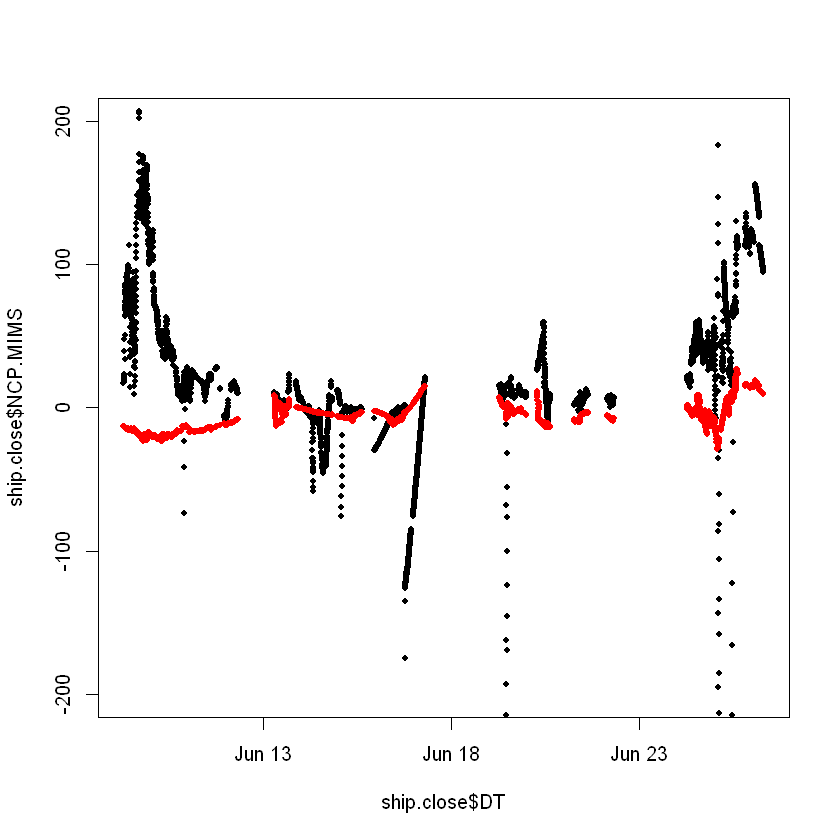

In [19]:
plot(ship.close$DT, ship.close$NCP.MIMS, pch=20, ylim=c(-200,200))
points(ship.close$DT, ship.close$NCP.EIMS, pch=20, ylim=c(-200,200), col='red')

In [42]:
plot.cycle = function(cycle, data) {
    l = which(data$Cycle == cycle)
    
    plot(ship.close$DT[l], ship.close$NCP.MIMS[l], pch=20, ylim=c(-100,100), main=cycle, ylab='NCP', xlab='')
    points(ship.close$DT[l], ship.close$NCP.EIMS[l], pch=20, ylim=c(-100,100), col='red')
    legend(min(ship.close$DT[l]), -50, c('MIMS', 'EIMS'), col=c('black', 'red'), lwd=4, cex=0.7)
    
    cols = make.div.pal(ship.close$NCP.MIMS, n = 100, lim = c(-200,200))
    plot(ship.close$LO[l], ship.close$LA[l], pch=16, cex=1.2, ylab='Latitude', xlab='Longitude', col=cols)
}

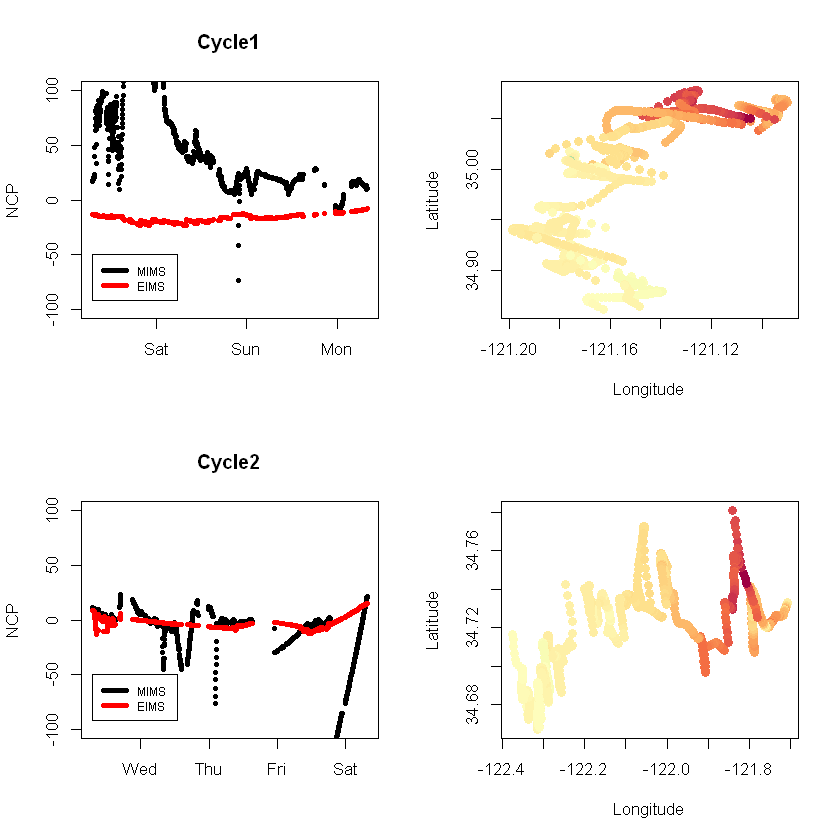

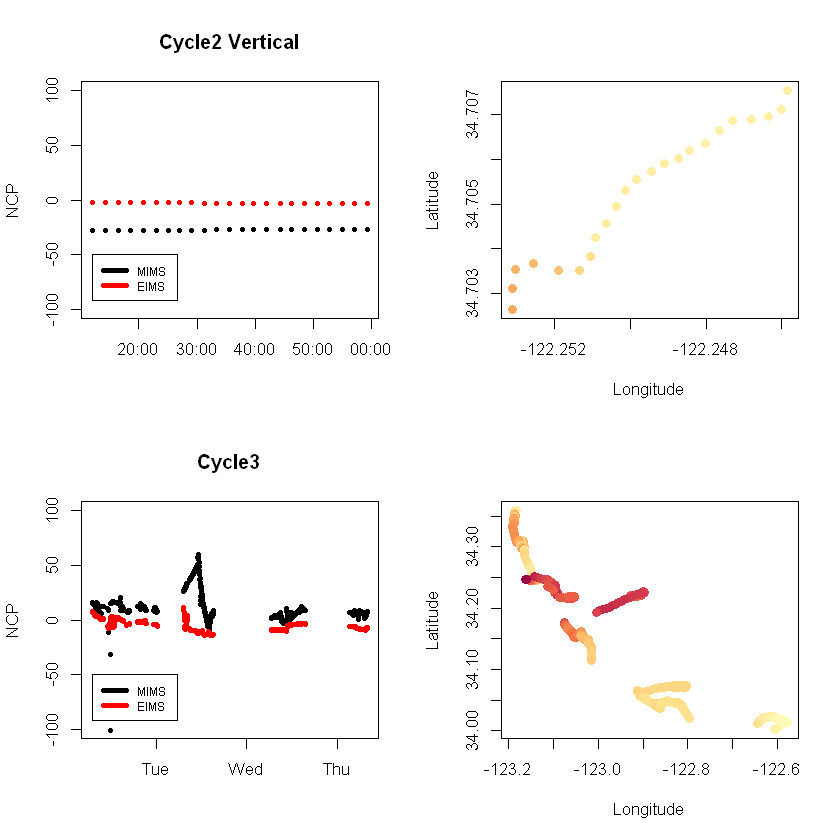

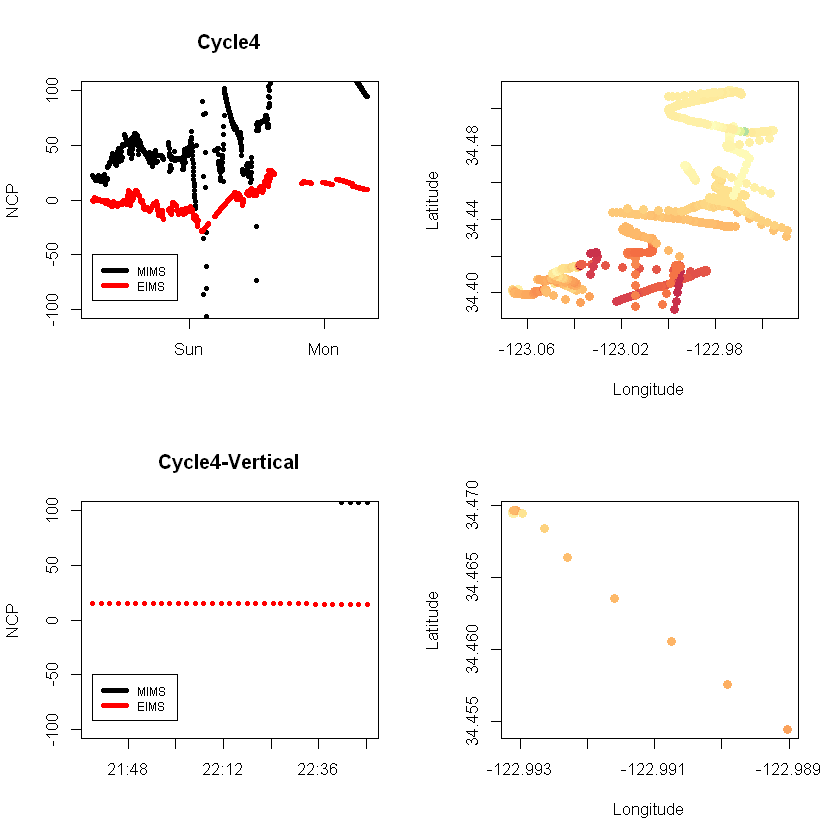

In [43]:
par(mfrow=c(2,2))
for (i in unique(ship.close$Cycle)) {
    plot.cycle(i, ship.close)
}

# GPP

In [3]:
load('RStates/CTD.pos.rdata')
load('RStates/ship.final.30min.rdata')

In [4]:
get.ship = function(time) {
    dt = as.numeric(abs(difftime(time, ship.data$DT, units = 'hours')))
    
    ship.data[which.min(dt),]
}

calculate.gpp = function(time) {
    ## Load FRRF data
    fit = load.frrf(time)
    
    ## Get ship.data
    ship = get.ship(time)
    
    par = ship$PA[1]
    mld = ship$MLD[1]
    chl = ship$FL[1]
    trans = 0.9
    
    GPP = 0
    for (i in seq(0, mld, 0.1)) {
        light = par * (trans ^ i)^2
        j = which.min(abs(fit$pred$x - light))
        jvp = fit$pred$y[j]
        GPP = GPP + jvp * 0.1 / (4 * 1.4) * 86400
    }
    GPP
}

In [5]:
frrf.path = 'RStates/FRRF/'
frrf.files = list.files(path = 'RStates/FRRF')

frrf.times = lapply(frrf.files,
                    function(x) {
                        as.POSIXct(as.numeric(strsplit(x, '.rdata')[[1]]), origin="1970-01-01", tz = 'GMT')
                    }
                   )

In [6]:
load.frrf = function(time) {
    dt = abs(as.numeric(frrf.times) - as.numeric(time))
    i = which.min(dt)
    load(paste0(frrf.path, frrf.files[i]))
    
    fit
}

In [7]:
ship.data$MLD[is.na(ship.data$MLD)] = 20

In [8]:
ship.data$GPP = 0

for (i in 1:nrow(ship.data)) {
    ship.data$GPP[i] = calculate.gpp(ship.data$DT[i])
}


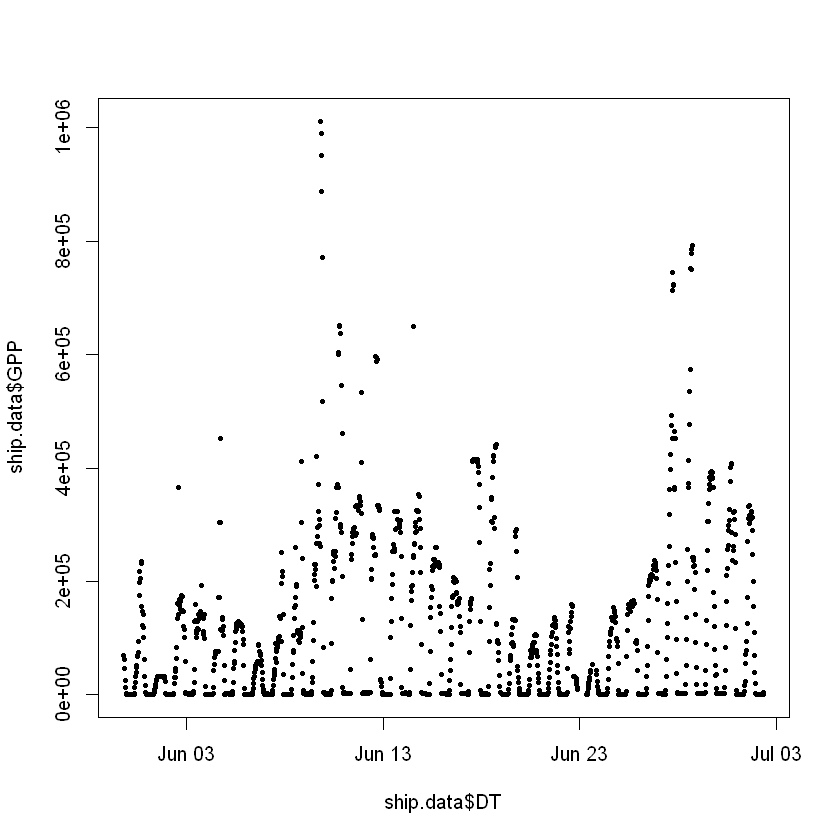

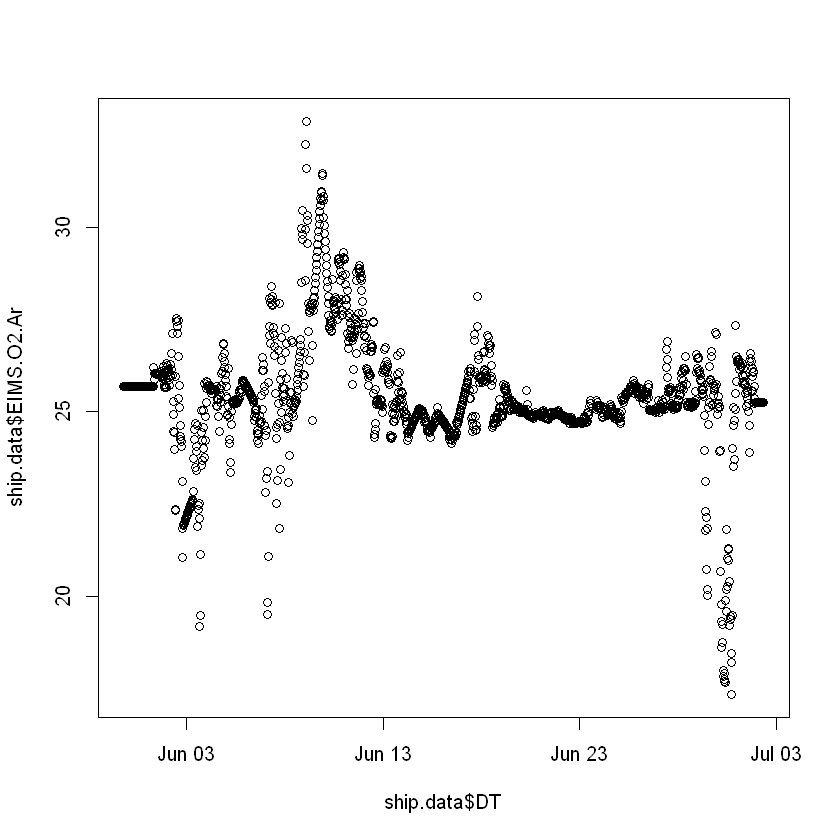

In [12]:
plot(ship.data$DT, ship.data$GPP, pch=16, cex=0.5)
plot(ship.data$DT, ship.data$EIMS.O2.Ar)